In [23]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

In [123]:
uvel_merged = xr.open_dataset('/swot/SUM01/spencer/swot_agulhas_surf/uvel.nc')
vvel_merged = xr.open_dataset('/swot/SUM01/spencer/swot_agulhas_surf/vvel.nc')
uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [124]:
with ProgressBar():
    uhat2 = xrft.power_spectrum(grid.interp(uvel_merged.U,'X')[:,0:200],dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(grid.interp(vvel_merged.V,'Y',boundary='fill')[:,0:200],dim='time', detrend='linear', window=True).compute()
ekehat_eul = .5*(uhat2 + vhat2)


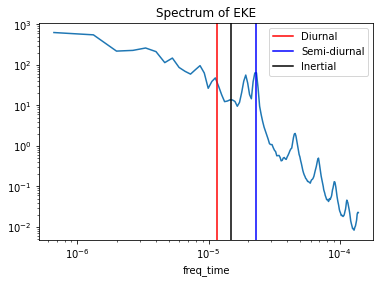

In [125]:
f = 2*2*np.pi/24/3600*np.sin(-40*np.pi/180)
ekehat_eul.mean(['i','j'])[210:].plot()
plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
plt.axvline([-f/2/np.pi],label='Inertial',color='k')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of EKE')

fig=plt.gcf()
fig.savefig('agulhas_spectrum.pdf')

In [118]:
ds = xr.open_zarr('/swot/SUM01/spencer/run_1week_rechunked.zarr')

In [119]:
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)
ds = ds.dropna('npart')

In [120]:
mask_roundx = abs(ds.x.diff('time')).max('time')
mask_roundy = abs(ds.y.diff('time')).max('time')
ds = ds.where(mask_roundx<30)
ds = ds.where(mask_roundy<30)
ds = ds.dropna('npart')

In [121]:
with ProgressBar():
    uhat2 = xrft.power_spectrum(ds.u.drop('niter'),dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(ds.v.drop('niter'),dim='time', detrend='linear', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

[########################################] | 100% Completed |  1min 43.4s
[########################################] | 100% Completed |  1min 50.6s


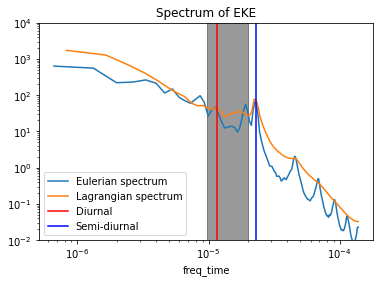

In [132]:
f1 = 2*2*np.pi/24/3600*np.sin(-60*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-25*np.pi/180)
ekehat_eul.mean(['i','j'])[210:].plot(label="Eulerian spectrum")
ekehat.mean(['npart'])[169:].plot(label='Lagrangian spectrum')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of EKE')
plt.ylim(10**-2,10**4)

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang.pdf')

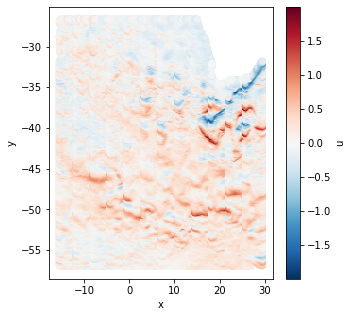

In [90]:
plt.figure(figsize=(5,5))
ds.sel(time=0).plot.scatter(x='x',y='y',hue='u')

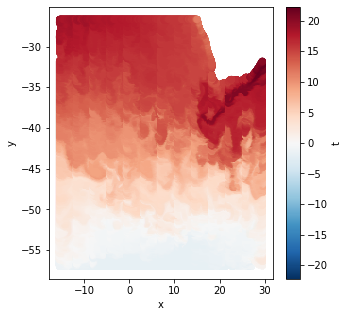

In [91]:
plt.figure(figsize=(5,5))
ds.sel(time=0).plot.scatter(x='x',y='y',hue='t')

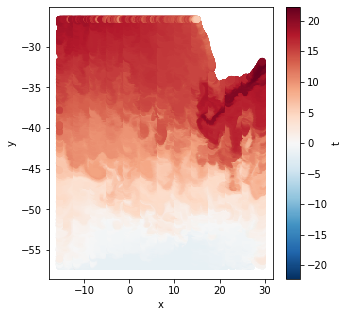

In [97]:
plt.figure(figsize=(5,5))
ds.sel(time=3600).plot.scatter(x='x',y='y',hue='t')